# Experimentation Guided Example


Over the past several checkpoints we've walked through many of the elements of good experimentation, covering statistical tests, research proposals, and more. But things are always a little different in the wild, so now we're going to put many of these elements together and walk through an example of what an experiment might look like when you're actually running it. The goal here is to see how the pieces fit together.

This is an interactive guided example. Changes you make to the version of this notebook on Thinkful's servers won't stick around. Make a copy of this notebook right now and save it to your local environment so that you'll have your own version, then switch over to that version.

## Setting the Stage

So let's talk about the scenario. For this example we're going to use a generic marketing scenario focused on email conversion. Many companies in a variety of industries run email campaigns to get people to sign up for a service.  Even if your interest is not in marketing, any experiment designed to elicit a discrete response will be similarly constructed.

Our theoretical company is a social networking site, called BlueBird. BlueBird has been using the same advertising email for years, and some at the company are starting to feel that it's getting a little stale. Ever the data driven individual, you propose an experiment. The marketing department draws up a new version of the email, and you'll conduct an A/B test comparing the two emails.

## Before Rollout

You may want to roll out the experiment right away, but there is so much to do beforehand! Getting an experiment ready to go out the door is serious business. It will make everything that comes after easier and make sure you're making well thought out decisions all the way through.

Now the research proposal or similar document can play a huge role in this prep process. That should contain a detailed description of the motivation of the experiment, what exactly the change is, and a plan for rollout. For this experiment, let's highlight a few elements of the research proposal here, rather than report the whole document.

**Copy of Both Emails**. This is useful so that anyone looking into the experiment can use the research proposal to actually see what happens.

**Rollout Plan**. Knowing how many people you intend to treat with your new email and how long this is going to take is important. It's not only a key aspect of the experiment itself, but also something you're likely to be asked about by other people who care about the outcome. Often times, though 50:50 rollouts are the fastest, a gradual rollout will be used to ensure that there are no negative consequences of the experiment or if things are broken or severely degraded it can be rolled back quickly. In this case we'll do two weeks at 10% and then two weeks at 50%. That will lead to about 30,000+ in treatment, which is a nice sized sample.

_As a note, if you want to do a more rigorous calculation of sample size, you can do power calculations beforehand. Power is the probability of rejecting a false null hypothesis. This uses the formula for t-test to see what effect would be detectable at a given sample size also referred to as 'N'._

**Success Metric**. It may seem obvious, but defining success before rolling out an experiment is a key thing to do. Usually this means picking the key metric of interest and setting the degree of significance you want to have. For a t-test this is typically a p-value of .05, and that's what we'll do here. Our success metric will be signups (also called conversions).

**Secondary Metrics**. It's easier to evaluate success if you have one success metric, but that doesn't mean that's all you look at. There can be many other metrics of interest, and monitoring them will ensure that you're not having an adverse effect on other things that matter. In this case let's make time from email to signup a secondary metric.

**Other Things to Do...**

You should also _test the infrastructure_, if any, before rolling out. In this case that means making sure the email is set up properly to be sent out when the experiment turns on. If it's manual, that's pretty easy (make sure it's formatted properly and the email is generally deliverable). If you use a service, sending some test emails to test accounts is probably a good idea. This can be either an engineering or a data science task, depending on complexity.

Make sure you have a _method for randomly sampling subjects_, and know if people stay in test or control permanently. This can matter for something like emails if people receive multiple messages. Should they only receive the new style of email or should each email be random? For simplicity, we'll assume each individual is only emailed once.

This is also a good time to check if there is any potential _collision with other events or experiments_. You want to run experiments in times that are representative of standard operations (unless your experiment is explicitly about how to handle an extreme situation). If you were testing marketing strategies for football betting behavior right before the Super Bowl, for example, you might see some weird behaviors that would make your findings not broadly applicable. You also don't want to test two things that are related at the same time.

Another consideration is _segmentation_ of your sample. Sometimes you don't want to test on the entire population. Maybe you'll pick specific cities (in which case it may be appropriate to sample those in a representative fashion) or test a specific age group or tenure of user. Make these decisions early as they will help inform later analysis and possibly how the experiment is functionally set up. For here we'll just assume we're small enough to test on the entire population.

Finally, it is good practice to give everyone a chance to _review the research proposal and provide feedback_. Sometimes this is done through a kickoff meeting while other companies may have less formal processes. Make sure everyone involved is aware of the plan and bought in before rolling out.

After all of this is done, and the boxes are all checked, you're ready to roll. Let's say we flipped the switch and turned the experiment on at 10% on April 1, 2016.

## Two Weeks In

Of course, you would monitor the experiment throughout its time in the wild, but two weeks in when considering turning up the proportion is a good time to do some analytics to see how things are performing before you roll forward to 50%.

We've [got a file](https://github.com/Thinkful-Ed/data-201-resources/blob/master/1.4.11_experimentation_guided_example/experiment_data_2_wks.csv) for what the data looks like up to this point. Save this CSV to your local environment in the same folder as your notebook as `experiment_data_2_wks.csv`.

In [3]:
from scipy import stats

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import weightstats as stests

In [86]:
PATH = 'data-201-resources/1.4.11_experimentation_guided_example/experiment_data_2_wks.csv'
experiment_data = pd.read_csv(PATH)

Let's take a look at the data

In [9]:
experiment_data.shape

(33613, 4)

In [65]:
experiment_data.head()

,treatment_date,test,is_signed_up,signup_date
0,2016-04-01,0,0,NaN
1,2016-04-01,0,0,NaN
2,2016-04-01,0,0,NaN
3,2016-04-01,0,0,NaN
4,2016-04-01,0,0,NaN


OK, so the data seems to have a few columns. `treatment_date` shows the date of the email being sent. `test` is a binary indicator if they were in test or control. `is_signed_up` shows if they successfully signed up. `signup_date` is the date of signup. Simple enough.

But how are things going? Let's write some code to see.

__Answer the questions below about this data to see how the experiment is developing__

In [67]:
# How large is each group?
experiment_data.test.value_counts()

0    46867
1    19861
Name: test, dtype: int64

In [68]:
# what is the ratio of those who convered to those who didn't
round(experiment_data.is_signed_up.value_counts()[1]/experiment_data.is_signed_up.value_counts()[0], 2)

0.27

In [13]:
# What is the signup rate of test and control?
round(np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[0], 3)

0.147

15% conversion for those not in test

In [14]:
round(np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[1], 3)

0.137

14% conversion for those in the test

#### Ho = there is no difference in conversion between those who receive the test and those who don't

#### Ha = there is a statistically significant difference in conversion between those who receive the test and those who dont

Is the experiment already significant?

In [87]:
stats.ttest_ind(experiment_data.loc[experiment_data.test == 1, 'is_signed_up'],
                experiment_data.loc[experiment_data.test == 0, 'is_signed_up'])

Ttest_indResult(statistic=-1.5711354292574262, pvalue=0.11616060761145311)

No since the p-value is over .05%. Meaning we can't reject the null hypothesis that there is no statistical difference between the datasets.

### Using 2 Sample Proportion Z-test

#### 1st - Computed Manually

In [73]:
# proportion who converted who weren't in the test
round(np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[0], 3)

0.147

In [74]:
# proportion who converted who were in the test
round(np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[1], 3)

0.137

In [75]:
# total amount of people either tested or not
sum(experiment_data.test.value_counts())

33613

In [76]:
# amount who responded divided by total everyone either tested or not
np.sum(experiment_data.is_signed_up ==1)/sum(experiment_data.test.value_counts())

0.1460744354862702

In [77]:
# computing manually using the numbers above hard coded
(.147 - .137)/ \
(np.sqrt((.146*(1-.146))*(2/33613)))

3.671413298545785

But my answer doesn't agree with the answer using statsmodels :(

#### 2nd - Computed using statsmodels
https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html

In [21]:
# how many people responded without receiving the test?
np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1))

4448

In [22]:
# how many people responded after receiving the test?
np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1))

462

In [23]:
# how many people did not receive the test?
np.sum((experiment_data.test == 0))

30241

In [24]:
# how many people received the test?
np.sum((experiment_data.test == 1))

3372

In [89]:
from statsmodels.stats.proportion import proportions_ztest

# the number of people who converted based on the test
count = np.array([np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1)), 
                  np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1))])

# the number of people who received the test, and those who haven't
nobs = np.array([np.sum((experiment_data.test == 1)), np.sum((experiment_data.test == 0))])

stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))
print(stat)

0.116
-1.571124480864239


It appears the p-value results of using the proportions ztest isn't different than the p-value using the t-test

#################################################################

Here's an example of how this code could look. Don't look at it until after trying on your own.

Seriously. Try it yourself first. 

![NYC at night](assets/nyc.gif)

In [26]:
# How large is each group?
print('test sample size:', len(experiment_data[experiment_data.test == 1]))
print('control sample size:', len(experiment_data[experiment_data.test == 0]))
print('test proportion:', experiment_data.test.mean())
print()

# What is the signup rate of test and control?
print('test signup rate:', experiment_data[experiment_data.test == 1].is_signed_up.mean())
print('control signup rate:', experiment_data[experiment_data.test == 0].is_signed_up.mean())

# Are the test and control groups significantly different?
stats.ttest_ind(experiment_data[experiment_data.test == 1].is_signed_up,
                experiment_data[experiment_data.test == 0].is_signed_up)

test sample size: 3372
control sample size: 30241
test proportion: 0.10031832921786214

test signup rate: 0.13701067615658363
control signup rate: 0.14708508316523924


Ttest_indResult(statistic=-1.5711354292574262, pvalue=0.11616060761145311)

So the groups are not significantly different, and indications do not seem great. The test signup rate seems lower than the old message. Can you see any reason why?

**Use the cell below to write some code to investigate. It might be worth looking at the secondary metric:**

In [27]:
experiment_data['treatment_date'] = pd.to_datetime(experiment_data['treatment_date'])
experiment_data['signup_date'] = pd.to_datetime(experiment_data['signup_date'])

In [28]:
experiment_data['dif'] = experiment_data.signup_date - experiment_data.treatment_date

In [29]:
experiment_data.loc[(experiment_data.test == 1) & (experiment_data.is_signed_up ==1), 'dif'].mean()

Timedelta('4 days 06:48:18.701298')

In [30]:
experiment_data.loc[(experiment_data.test == 0) & (experiment_data.is_signed_up ==1), 'dif'].mean()

Timedelta('3 days 04:29:40.575539')

recipients who weren't in the experiment signed up faster compared to those who were

#################################################################################

Here's another example of how this code could look. Don't look at it until after trying on your own.

![What a lovely contrast to NYC](assets/forest.gif)

In [31]:
# side note about code
# interesting how they are grabbing just two columns, then doing the groupby, which means they don't have to call out
# which column to aggregate on

# where I usually have done the groupby on all the columns, then had to select which column to agreggate on
experiment_data[experiment_data.test==1][
    ['treatment_date', 'is_signed_up']].groupby('treatment_date').mean().head()

,is_signed_up
treatment_date,
2016-04-01,0.237443
2016-04-02,0.207031
2016-04-03,0.202247
2016-04-04,0.215625
2016-04-05,0.246154


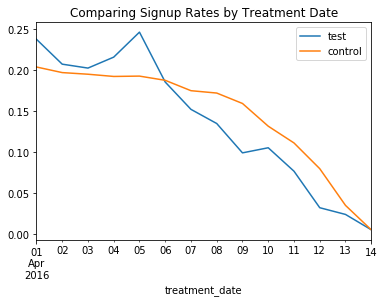

T-Test Results by Date
Ttest_indResult(statistic=1.171015382328547, pvalue=0.24172432121696255)
Ttest_indResult(statistic=0.39163213374090855, pvalue=0.6953630758340448)
Ttest_indResult(statistic=0.24114731791032132, pvalue=0.8094651742723448)
Ttest_indResult(statistic=1.006146671265253, pvalue=0.3144281887767212)
Ttest_indResult(statistic=1.7950152227404037, pvalue=0.0727950243234006)
Ttest_indResult(statistic=-0.07142256949339083, pvalue=0.943068118381282)
Ttest_indResult(statistic=-0.99645401324533, pvalue=0.31911047625459077)
Ttest_indResult(statistic=-1.4059315672051254, pvalue=0.1598930922410899)
Ttest_indResult(statistic=-2.772772511643487, pvalue=0.0055926512303104605)
Ttest_indResult(statistic=-1.301097855458891, pvalue=0.19332775805677105)
Ttest_indResult(statistic=-1.6243695706046337, pvalue=0.10443285596458776)
Ttest_indResult(statistic=-2.559540254853317, pvalue=0.010550250694229046)
Ttest_indResult(statistic=-0.851793126290792, pvalue=0.3944212121535955)
Ttest_indResult(s

In [32]:
# Some example code...

fig = experiment_data[experiment_data.test==1][
    ['treatment_date', 'is_signed_up']].groupby('treatment_date').mean().plot()
experiment_data[experiment_data.test==0][
    ['treatment_date', 'is_signed_up']].groupby('treatment_date').mean().plot(ax=fig)
plt.legend(['test','control'])
plt.title('Comparing Signup Rates by Treatment Date')
plt.show()


# Generate a test statistic comparing test and control on treatment date
print('T-Test Results by Date')

for date in experiment_data.treatment_date.unique():
    dated_data = experiment_data[experiment_data.treatment_date == date]
    print(stats.ttest_ind(dated_data[dated_data.test == 1].is_signed_up,
                          dated_data[dated_data.test == 0].is_signed_up))

Right. So what you see is that the test group is converting slower than the control group. But if you look just at the group treated in the first few days, they're not that different in signup rate. The rates seem to converge as time passes after sending the email.

This means the difference could be a time effect rather than a rate effect. Time plays a huge role in almost all experiments. Not all behaviors are immediate. Sometimes it takes a while to figure out a new feature. Other times there is novelty effect from the new feature that leads to a spike in activity. Letting these things play out is an inexact, but important, feature of experimental design.

We could wait here, but that time feature has me feeling pretty comfortable that any damage to signup rate will get lower with time, so I say let's roll out to 50% for another two weeks.

## Experiment Wrap Up

Two more weeks go by and you have enough people in your sample so you now turn the experiment off. No more users will be given a test email. Now it's time to analyze what happened and see how the new email is performing.

This [final data set](https://github.com/Thinkful-Ed/data-201-resources/blob/master/1.4.11_experimentation_guided_example/experiment_data_final.csv) comes from a few weeks after the experiment is turned off to account for some of those time effects. Again, save this in the same folder as your notebook.

Let's answer the same basic questions again.

In [80]:
PATH = 'data-201-resources/1.4.11_experimentation_guided_example/experiment_data_final.csv'
experiment_data = pd.read_csv(PATH)

In [34]:
experiment_data.head()

,treatment_date,test,is_signed_up,signup_date
0,2016-04-01,0,0,NaN
1,2016-04-01,0,0,NaN
2,2016-04-01,0,0,NaN
3,2016-04-01,0,0,NaN
4,2016-04-01,0,0,NaN


In [35]:
experiment_data.shape

(66728, 4)

In [62]:
# How large is each group?
print('test sample size:', len(experiment_data[experiment_data.test == 1]))
print('control sample size:', len(experiment_data[experiment_data.test == 0]))
print('test proportion:', experiment_data.test.mean())
print()

# What is the signup rate of test and control?
print('test signup rate:', experiment_data[experiment_data.test == 1].is_signed_up.mean())
print('control signup rate:', experiment_data[experiment_data.test == 0].is_signed_up.mean())

# Is the experiment already significant?
stats.ttest_ind(
    experiment_data[experiment_data.test == 1].is_signed_up,
    experiment_data[experiment_data.test == 0].is_signed_up)

test sample size: 19861
control sample size: 46867
test proportion: 0.2976411701234864

test signup rate: 0.2421328231206888
control signup rate: 0.19937269293959503


Ttest_indResult(statistic=12.368130184147793, pvalue=4.248167714911685e-35)

Well hey now. This experiment got very significant after allowing for more time. (It's almost like someone made it that way.) Why don't you create some visualizations to tell the story of the effect of the new email?

**Write your code in the cell below:**

### Using 2 Sample Proportion Z-test

#### 1st - Computed Manually

In [82]:
# proportion who converted who weren't in the test
round(np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[0], 3)

0.199

In [83]:
# proportion who converted who were in the test
round(np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1)) / experiment_data.test.value_counts()[1], 3)

0.242

In [84]:
# everyone either tested or not
sum(experiment_data.test.value_counts())

66728

In [85]:
# amount who responded divided by total everyone either tested or not
np.sum(experiment_data.is_signed_up ==1)/sum(experiment_data.test.value_counts())

0.2120998681213284

In [41]:
# computing manually using the numbers above
(.199 - .242)/ \
(np.sqrt((.212*(1-.212))*(2/66728)))

-19.216596565593825

#### 2nd - Computed using statsmodels
https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html

In [81]:
# the number of people who converted based on the test
count = np.array([np.sum((experiment_data.test == 1) & (experiment_data.is_signed_up ==1)), 
                  np.sum((experiment_data.test == 0) & (experiment_data.is_signed_up ==1))])

# the number of people who received the test, and those who haven't
nobs = np.array([np.sum((experiment_data.test == 1)), np.sum((experiment_data.test == 0))])

stat, pval = proportions_ztest(count, nobs)
print('{0:0.50f}'.format(pval))
print(stat)

0.00000000000000000000000000000000004625476886928066
12.354162568395353


The p-value from the proportions ztest score is about the same as the p-value from the t-test above

### Plotting results

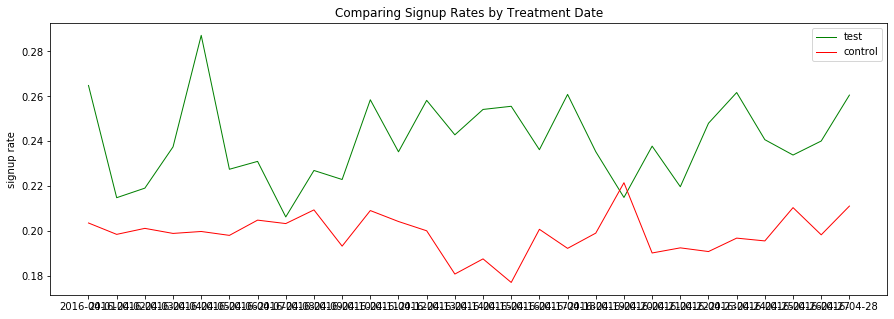

In [42]:
# this plotting syntax is a bit different for me

# fig = experiment_data[experiment_data.test==1][
#     ['treatment_date', 'is_signed_up']].groupby('treatment_date').mean().plot()
# experiment_data[experiment_data.test==0][
#     ['treatment_date', 'is_signed_up']].groupby('treatment_date').mean().plot(ax=fig)


# this is what I'm more use to, which gives me more control over the colors of the lines
# but I suppose that's not very important
plt.figure(figsize=(15, 5))

x = experiment_data['treatment_date'].unique()
y1 = experiment_data[experiment_data.test==1][['treatment_date', 'is_signed_up']].groupby('treatment_date').mean()
y2 = experiment_data[experiment_data.test==0][['treatment_date', 'is_signed_up']].groupby('treatment_date').mean()

plt.plot(x, y1, color='green',linewidth=1)
plt.plot(x, y2, color='red',linewidth=1)

plt.legend(['test','control'])
plt.ylabel('signup rate')
plt.title('Comparing Signup Rates by Treatment Date')
plt.show()

Great! So what are the conclusions from this experiment?

The new email seems to be a significant improvement on the old email, but at a slower rate of conversion. So as long as BlueBird isn't desperate for signups in the next few days, the change seems worth it. In this case, however, it would also be worth working with the advertising and engineering teams to see if you could figure out why conversation was slower for the test email. That could inform whether the effect might change over time.


## Conclusions

This analysis, while comprehensive, is not exhaustive. There are plenty of more topics and dimensions that could be explored. Talk with your mentor about how you might expand this experiment or other dimensions you may want to investigate.



One last thing. It's worth having an additional note on t-testing here again. We used a t-test in this exercise, but we could actually use a different test to gain a bit more power. Because the sample is a proportion, we know more about their distributions than the t-test assumes. Specifically, the distribution of the mean is normal, meaning we could use something called a two sample proportional z-test. We haven't covered this test yet, but you can read about it [here](https://onlinecourses.science.psu.edu/stat414/node/268). Find a python implementation for this test and go back and revise our testing. What difference does our new test make?

#### two sample proportions z-test doesn't seem to be any different for me, I'm not sure what I'm doing wrong